# Clustering and Annotation of cell segmentations, trial 3

Segmentation was performed with Baysor
*Remember: The Baysor preview is vertically mirrored from Visualizer*

this is a copy of 'clustering_EDA.ipynb', but using the results from the second clustering trial:
just testing baysor parameters on a small tile of the tissue

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import anndata as ad
import pickle as pk

## Importing some stuff

In [2]:
# Orginal MERSCOPE transcripts
genes = pd.read_csv("../data/detected_transcripts_wPixel.csv")

In [3]:
genes.head()

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,global_xpixel,global_ypixel
0,161,0,205.033570,3673.6423,0.0,1898.4589,679.20660,0,CD4,ENST00000011653,1898.457695,34015.183434
1,1202,0,127.298164,3624.1118,2.0,1178.6866,220.59117,0,CD4,ENST00000011653,1178.685905,33556.568004
2,3738,0,102.508125,3625.4592,6.0,949.1493,233.06530,0,CD4,ENST00000011653,949.148662,33569.043922
3,11489,3,146.474410,3673.4827,4.0,1356.2445,677.72650,0,CD22,ENST00000085219,1356.243618,34013.705657
4,13130,4,138.442900,3771.7260,0.0,1281.8787,1587.38840,0,TBX21,ENST00000177694,1281.877835,34923.365226


In [13]:
# Baysor predictions
dat = pd.read_csv("../02-Baysor/test/segment_m150_std50_s35_compweight02/segmentation.csv")
dat.describe()

,Column1,Unnamed: 0,barcode_id,global_x,global_y,z,x_reserved,y_reserved,fov,x,y,molecule_id,confidence,cluster,cell,assignment_confidence
count,3.927400e+05,3.927400e+05,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000,392740.000000
mean,3.503807e+07,7.607694e+05,174.408171,8103.291887,4656.839216,3.037562,1020.085977,1017.593480,1039.589497,75030.429595,43118.852415,196370.500000,0.743905,2.646214,703.794923,0.905717
std,1.009964e+06,4.996789e+05,112.763752,137.042058,143.148043,1.978064,533.864894,504.313737,18.729509,1268.907087,1325.443947,113374.416697,0.386655,0.835819,538.425105,0.151474
min,3.233700e+07,4.000000e+00,0.000000,7776.006000,4428.003400,0.000000,98.012950,98.001870,987.000000,72000.006771,41000.003701,1.000000,0.000000,1.000000,0.000000,0.050000
25%,3.437215e+07,3.334095e+05,76.000000,8001.293800,4539.056625,1.000000,563.754163,582.034165,1025.000000,74086.003506,42028.273607,98185.750000,0.594095,2.000000,172.000000,0.850000
50%,3.469480e+07,7.290030e+05,173.000000,8121.745000,4643.340500,3.000000,977.326050,1026.287400,1035.000000,75201.291639,42993.864387,196370.500000,0.978860,3.000000,701.000000,1.000000
75%,3.651930e+07,1.094781e+06,249.000000,8214.525500,4762.029325,5.000000,1509.361375,1431.287100,1067.000000,76060.369761,44092.834245,294555.250000,0.992750,3.000000,1181.000000,1.000000
max,3.672171e+07,1.892094e+06,397.000000,8316.005000,4968.002000,6.000000,1949.994400,1949.983600,1069.000000,76999.994124,45999.987351,392740.000000,0.995280,4.000000,2034.000000,1.000000


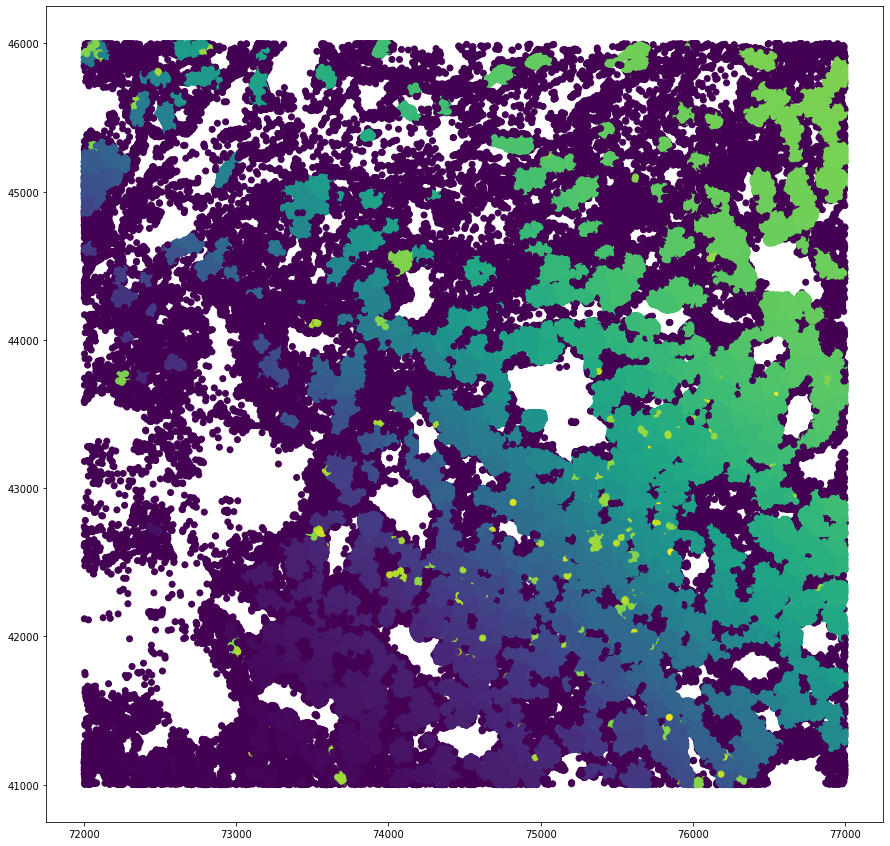

In [35]:
plt.figure(figsize=(15, 15))
plt.scatter(dat['x'], dat['y'], c=dat['cell'])
plt.show()

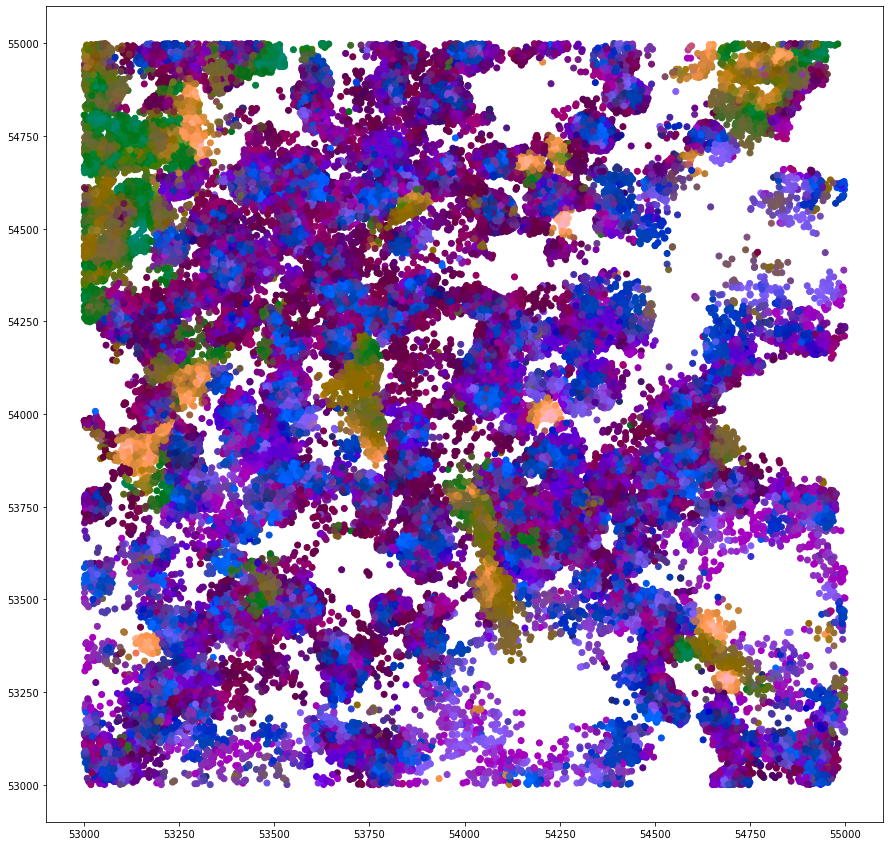

In [31]:
plt.figure(figsize=(15, 15))
plt.scatter(dat['x'], dat['y'], c=dat['ncv_color'])
plt.show()

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


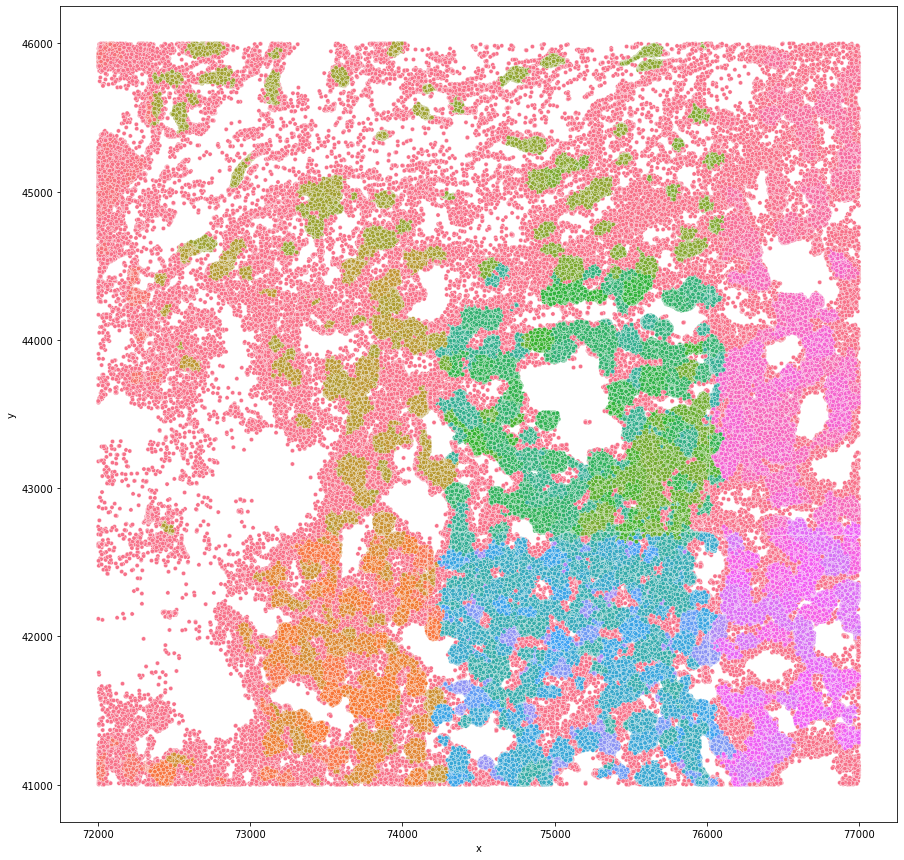

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
out = sns.scatterplot(dat['x'], dat['y'], hue=dat['cell'].astype(str), size=0.1, legend=False)
# out = out.get_figure()
# out.savefig("plots/small_seg_2_m200.png")
plt.show()

## Making an AnnData object

I'll need two dataframes; count matrix, and metadata
- collapse on cell ID
- count gene occurances
- average x, y coordinates
- average global coordinates
- median or mode cluster, should all be the same number

In [33]:
dat.columns

Index(['Unnamed: 0', 'barcode_id', 'global_x', 'global_y', 'z', 'x_reserved',
       'y_reserved', 'fov', 'gene', 'transcript_id', 'x', 'y', 'molecule_id',
       'prior_segmentation', 'confidence', 'cluster', 'cell',
       'assignment_confidence', 'is_noise', 'ncv_color'],
      dtype='object')

In [14]:
datTrim = dat[['cell', 'cluster' , 'gene', 'x', 'y', 'global_x', 'global_y']]
datTrim = datTrim[datTrim['cell'] != 0]
datTrim.head()

,cell,cluster,gene,x,y,global_x,global_y
1,463,1,CD4,72014.367872,45111.534249,7777.5570,4872.0490
2,589,1,CD4,72129.414091,45288.814684,7789.9820,4891.1953
3,589,1,CD4,72090.315043,45296.367457,7785.7593,4892.0110
4,589,1,CD4,72117.562247,45333.872061,7788.7020,4896.0615
5,505,1,CD4,72136.728901,45074.314830,7790.7720,4868.0293


In [15]:
count = datTrim.groupby(['cell', 'gene']).agg(count=('gene', 'count')).reset_index()
count = count.pivot(index='cell', columns='gene', values='count')
count.shape

(2034, 398)

In [16]:
meta = datTrim.groupby('cell').agg({
    'cluster':'first',
    'x':'mean',
    'y':'mean',
    'global_x':'mean',
    'global_y':'mean'})
meta.index = meta.index.map(str)
meta.head()

,cluster,x,y,global_x,global_y
cell,,,,,
1,2,72021.733177,41074.725001,7778.352453,4436.073306
2,2,72017.918508,41165.889973,7777.940469,4445.919130
3,3,72033.195123,41206.678458,7779.590344,4450.324289
4,3,72226.219408,41043.608904,7800.436981,4432.712765
5,3,72214.583776,41104.246172,7799.180332,4439.261594


In [17]:
count.fillna(0, inplace=True)
count.head()

gene,A2M,ABCC2,ABCG2,ABTB2,ACLY,ACSL1,ACTA2,ADAMTS9,ADCYAP1,ADGRB3,...,VIM,WWTR1,ZBTB16,ZBTB20,ZFAND3,ZFHX3,ZFPM2,ZHX2,ZNF331,ZNF804A
cell,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0


In [18]:
adata = ad.AnnData(count)

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
adata.obs = meta

In [2]:
adata.write('baysor_m150_s40_std50_seg.h5ad')
# adata = ad.read('baysor_seg.h5ad')

## Processing and Clustering

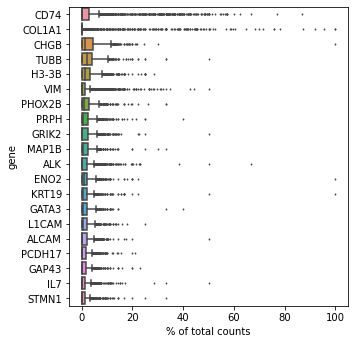

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20) # looks like there are cells that only contain one gene?

In [16]:
sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 41511 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes'
    var: 'n_cells'

In [21]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [22]:
adata.obs.describe()

,cluster,x,y,global_x,global_y,n_genes_by_counts,total_counts
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,2.633727,75064.782932,42927.692767,8107.002050,4636.193960,58.055064,159.425278
std,0.974875,1193.115589,1264.692346,128.856571,136.586866,37.508994,150.676636
min,1.000000,72003.176769,41010.309867,7776.348360,4429.116467,1.000000,1.000000
25%,2.000000,74272.101261,41945.735305,8021.392371,4530.142482,25.000000,36.000000
50%,3.000000,75246.976255,42674.047206,8126.678942,4608.800221,57.000000,123.000000
75%,3.000000,75973.742066,43794.958888,8205.169703,4729.858765,85.000000,236.000000
max,4.000000,76990.454316,45994.813836,8314.974700,4967.443260,156.000000,927.000000


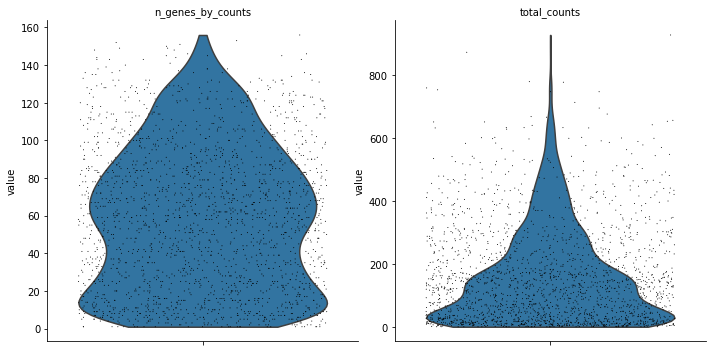

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

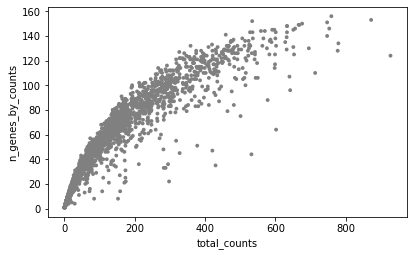

In [24]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [100]:
# adata = adata[adata.obs.total_counts < 2000, :]

In [25]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [26]:
adata.raw = adata

In [27]:
sc.pp.scale(adata)

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

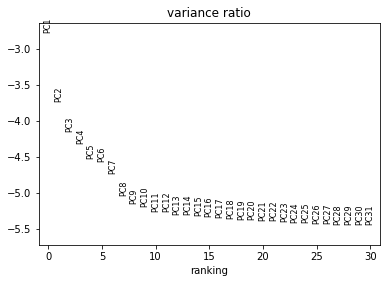

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

In [31]:
sc.tl.leiden(adata)

In [32]:
sc.tl.umap(adata)

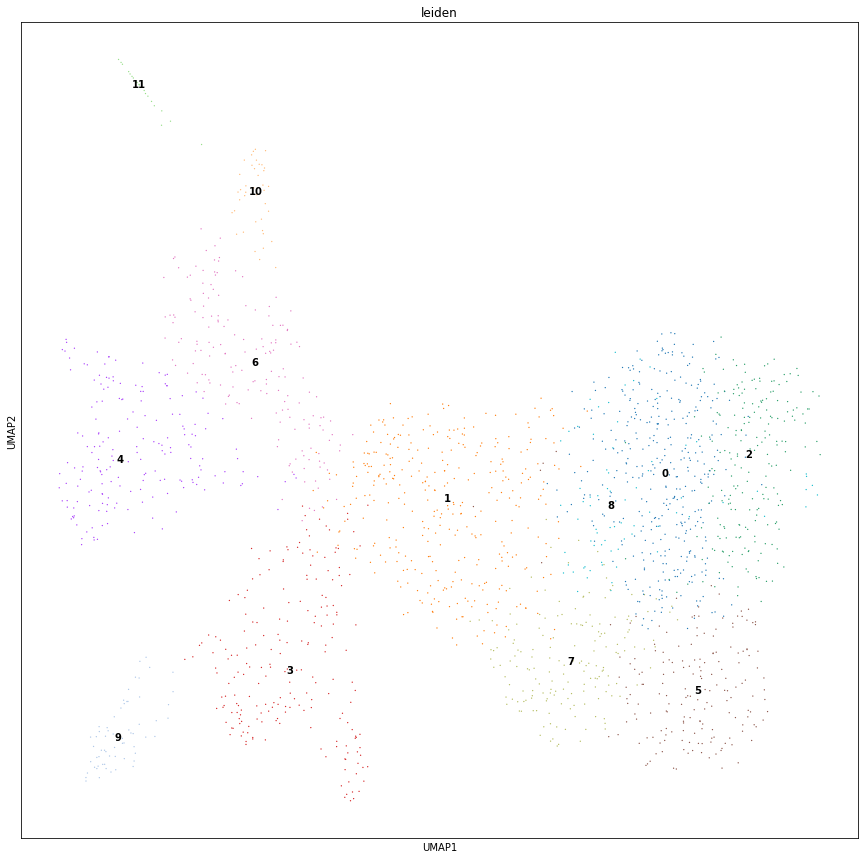

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size=7, legend_loc='on data')
plt.show()

In [34]:
with open('adata_m150_s35_std50_obs.pk', 'wb') as f:
    pk.dump(adata.obs, f)

In [28]:
adata.obs['x'].max()

107475.96995949162